In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

data['reliable'] = np.where(
    np.abs(data['I have frequent mood swings.'] - data['I change my mood a lot.']) > 3, 0, 1)

data = data[data.reliable == 1]
del data['reliable']

# Remove demographics
data = data.drop(['age', 'gender', 'country'], axis=1)

data.shape

(19331, 50)

First we need to see the appropriate number of factors. I propose doing this by taking the value of the **4th-smallest factor loading**.

Why 4th? Guadagnoli & Velicer (1988) consider a factor to be reliable if it has 4 or more loadings of at least 0.6, regardless of the sample size. So if this value is at least 0.6, then we've discovered a reliable factor.

In [7]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=10).fit(data)
fa1 = fa.transform(data)

# Stick it in a dataframe
factors = pd.DataFrame(fa.components_, columns=data.columns).T

for i in factors.columns:
    factors['absol'] = abs(factors[i])
    factors_sorted = factors.sort_values('absol', ascending=False).head(4) # Top 4
    print(i+1, factors_sorted['absol'].min())                              # Min value
    del factors['absol']

1 0.7890038356533742
2 0.5769291691675996
3 0.48134790904101926
4 0.41530312389254603
5 0.6349453468876078
6 0.31144677822842287
7 0.2761139041724975
8 0.2832483441134166
9 0.20293150294264048
10 0.1862022185394397


Notice that we find less and less variability as we add more factors! For machine learning, there isn't much harm in using too many factors, but in psychometrics, we need to follow the rule outlined above.

Let's create a new dataframe with our 5 factors and then see what they are.

1
AxesSubplot(0.125,0.125;0.775x0.755)


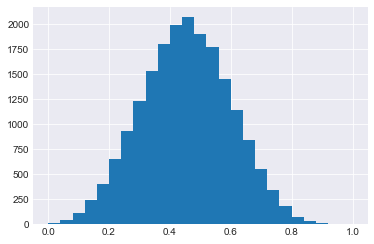

2
AxesSubplot(0.125,0.125;0.775x0.755)


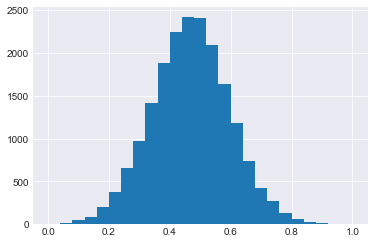

3
AxesSubplot(0.125,0.125;0.775x0.755)


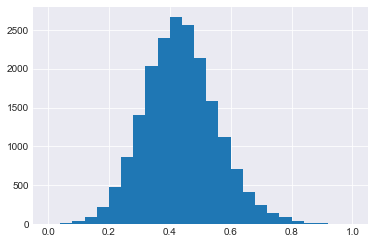

4
AxesSubplot(0.125,0.125;0.775x0.755)


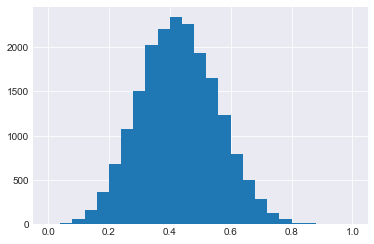

5
AxesSubplot(0.125,0.125;0.775x0.755)


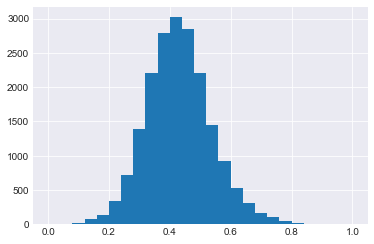

In [8]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import MinMaxScaler

fa = PCA(n_components=5).fit(data)
factors = fa.transform(data)

# Scale values
mms = MinMaxScaler().fit(factors)
factors = mms.transform(factors)

factors = pd.DataFrame(factors, columns=[str(n) for n in np.arange(1,6,1)])

# Let's look at the histograms as well...
for i in factors.columns:
    print(i)
    print(factors[i].hist(bins=25))
    plt.show()

Beauuutiful normal distributions.

# Investigating our factors

In [15]:
fa = FactorAnalysis(n_components=5).fit(data)

factors = pd.DataFrame(fa.components_, columns=data.columns).T

# Extraversion
f1 = factors[[0]]
f1['absol'] = np.abs(f1)
f1.sort_values('absol', ascending=False)[[0]].head(10)

,0
I talk to a lot of different people at parties.,-0.908
I feel comfortable around people.,-0.876
I start conversations.,-0.846
I am quiet around strangers.,0.749
I keep in the background.,0.715
I often feel blue.,0.712
I have little to say.,0.673
I have frequent mood swings.,0.672
I don't talk a lot.,0.671
I get irritated easily.,0.647


In [17]:
# Neuroticism
f2 = factors[[1]]
f2['absol'] = np.abs(f2)
f2.sort_values('absol', ascending=False)[[1]].head(10)

,1
I have frequent mood swings.,-0.758
I get upset easily.,-0.734
I change my mood a lot.,-0.719
I get stressed out easily.,-0.634
I get irritated easily.,-0.567
I worry about things.,-0.521
I often feel blue.,-0.510
I am easily disturbed.,-0.497
I feel others' emotions.,-0.488
I make a mess of things.,-0.445


In [18]:
# Agreeableness
f3 = factors[[2]]
f3['absol'] = np.abs(f3)
f3.sort_values('absol', ascending=False)[[2]].head(10)

,2
I sympathize with others' feelings.,-0.565
I insult people.,0.518
I have a soft heart.,-0.493
I feel others' emotions.,-0.492
I don't mind being the center of attention.,0.481
I don't like to draw attention to myself.,-0.442
I am not interested in other people's problems.,0.420
I follow a schedule.,-0.419
I keep in the background.,-0.399
I don't talk a lot.,-0.391


In [19]:
# Openness
f4 = factors[[3]]
f4['absol'] = np.abs(f4)
f4.sort_values('absol', ascending=False)[[3]].head(10)

,3
I use difficult words.,-0.654
I have a rich vocabulary.,-0.604
I am full of ideas.,-0.602
I have difficulty understanding abstract ideas.,0.538
I have excellent ideas.,-0.529
I have a vivid imagination.,-0.493
I do not have a good imagination.,0.468
I am not interested in abstract ideas.,0.445
I am quick to understand things.,-0.431
I spend time reflecting on things.,-0.349


In [20]:
# Conscientiousness
f5 = factors[[4]]
f5['absol'] = np.abs(f5)
f5.sort_values('absol', ascending=False)[[4]].head(10)

,4
I follow a schedule.,0.602
I get chores done right away.,0.587
I often forget to put things back in their proper place.,-0.582
I leave my belongings around.,-0.563
I like order.,0.473
I am always prepared.,0.452
I make a mess of things.,-0.384
I get irritated easily.,0.357
I am exacting in my work.,0.299
I shirk my duties.,-0.270


In [46]:
def show_items(factor):
    '''Returns a dataframe of correlations, sorted
    by absolute value'''
    f = pd.DataFrame(data.corrwith(factors[str(factor)]))
    f['absol'] = abs(f[0])
    return f.sort_values('absol', ascending=False).drop('absol', axis=1).head()

# This is like a mixture of extraversion and assertiveness
show_items(1)

,0
I get irritated easily.,0.026200
I am easily disturbed.,0.023442
I often feel blue.,0.021512
I keep in the background.,0.019053
I have frequent mood swings.,0.017948


# Factor analysis

In [32]:
from sklearn.decomposition import FactorAnalysis

original_num_items =data.columns
print(len(original_num_items), 'items total')

def get_factor(remaining=data.columns, threshold=0.65):

    fa = FactorAnalysis(n_components=1, random_state=200).fit(data[remaining])

    factor = pd.DataFrame(fa.components_, columns=data[remaining].columns).T

    factor.columns = [i+1 for i in factor.columns]
    factor['absol'] = abs(factor[1])
    
    remaining = factor[np.abs(factor[1]) < threshold].index
    factor = factor[factor.absol >= threshold]
    
    factor = pd.DataFrame(factor.sort_values('absol', ascending=False)[1])

    return factor, remaining


factor, remaining = get_factor(threshold=.72)

print(len(remaining), 'items remaining\n')

# Extraversion
factor

50 items total

43 items remaining



,1
I talk to a lot of different people at parties.,-0.990938
I start conversations.,-0.919648
I feel comfortable around people.,-0.919154
I am quiet around strangers.,0.810207
I keep in the background.,0.777479
I don't talk a lot.,0.759983
I have little to say.,0.724442


I'm still experimenting with the methodology, but if we're measuring psychological constructs, it's also important for the intercorrelations within each factor's items to be high (ideally 0.70 or greater).

In [33]:
def intercorrelations(factor=factor):
    factor_questions = factor.index
    intercorrelations = {}

    for i in factor_questions:
        corrs = abs(data[factor_questions].drop(i, axis=1).corrwith(data[i]))
        intercorrelations[i] = corrs.mean()

    return pd.DataFrame([intercorrelations]).T.sort_values(0, ascending=False)
    
intercorrelations()

,0
I start conversations.,0.552253
I talk to a lot of different people at parties.,0.525610
I don't talk a lot.,0.507406
I keep in the background.,0.507092
I feel comfortable around people.,0.498785
I am quiet around strangers.,0.494405
I have little to say.,0.458996


We can also look at the items that are most highly correlated with our strongest factor loading...

In [34]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I talk to a lot of different people at parties.,1.000000
I start conversations.,0.634175
I am the life of the party.,0.591438
I feel comfortable around people.,0.582116
I am quiet around strangers.,-0.538342
I keep in the background.,-0.509595
I don't talk a lot.,-0.481347
I don't mind being the center of attention.,0.436464
I have little to say.,-0.408088
I am interested in people.,0.359238


Lots of overlap. Let's zero in on it.

In [35]:
def overlap(factor=factor, corrs=corrs):
    factor_items = set(factor.index)
    corr_items = set(corrs.head(10).index)

    return factor_items.intersection(corr_items)

overlap()

{'I am quiet around strangers.',
 "I don't talk a lot.",
 'I feel comfortable around people.',
 'I have little to say.',
 'I keep in the background.',
 'I start conversations.',
 'I talk to a lot of different people at parties.'}

We should have very high confidence that these are all measuring the same phenomenon (in this case, extraversion).

Let's create a new feature using this factor!

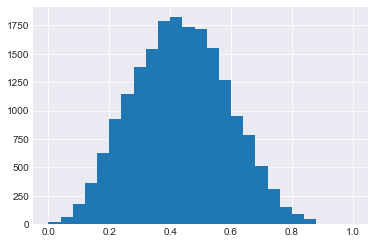

In [36]:
fa = FactorAnalysis(n_components=1).fit(data)
fa1 = fa.transform(data)

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(fa1)
fa1 = mms.transform(fa1)
data['factor_1'] = fa1

data['factor_1'].hist(bins=25)

In [37]:
absolute_correlations('factor_1', df=data)['correlation'].head(10)

factor_1                                           1.000000
I feel comfortable around people.                 -0.781335
I start conversations.                            -0.754155
I talk to a lot of different people at parties.   -0.726540
I keep in the background.                          0.667943
I am quiet around strangers.                       0.651322
I have little to say.                              0.614200
I am the life of the party.                       -0.608095
I don't talk a lot.                                0.607245
I am not really interested in others.              0.543837
Name: correlation, dtype: float64

# Factor 2

In [38]:
factor, remaining = get_factor(threshold=.69, remaining=remaining)

print(len(remaining), 'items remaining\n')

# Neuroticism
factor

36 items remaining



,1
I have frequent mood swings.,1.043084
I change my mood a lot.,0.973750
I get upset easily.,0.934647
I get irritated easily.,0.894693
I often feel blue.,0.864622
I get stressed out easily.,0.815052
I am easily disturbed.,0.695949


In [39]:
intercorrelations(factor)

,0
I have frequent mood swings.,0.552610
I change my mood a lot.,0.534313
I get upset easily.,0.528063
I get irritated easily.,0.503807
I get stressed out easily.,0.453549
I often feel blue.,0.446918
I am easily disturbed.,0.402935


In [40]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I have frequent mood swings.,1.000000
I change my mood a lot.,0.827954
I get upset easily.,0.553751
I often feel blue.,0.550588
I get irritated easily.,0.542046
I get stressed out easily.,0.441301
I am easily disturbed.,0.400020
factor_1,0.398537
I worry about things.,0.366616
I make a mess of things.,0.354297


In [41]:
# Definitely all measuring neuroticism
overlap(factor, corrs)

{'I am easily disturbed.',
 'I change my mood a lot.',
 'I get irritated easily.',
 'I get stressed out easily.',
 'I get upset easily.',
 'I have frequent mood swings.',
 'I often feel blue.'}

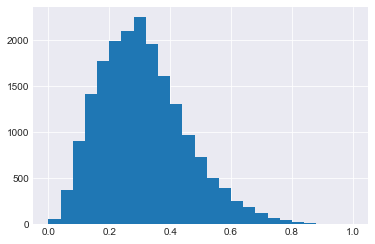

In [42]:
fa = FactorAnalysis(n_components=1).fit(data[remaining].values)
fa2 = fa.transform(data[remaining].values)

mms = MinMaxScaler().fit(fa2)
fa2 = mms.transform(fa2)
data['factor_2'] = fa2

data['factor_2'].hist(bins=25)

In [44]:
absolute_correlations('factor_2', df=data).head(10)

,correlation
factor_2,1.000000
I sympathize with others' feelings.,-0.759425
I feel others' emotions.,-0.738401
I am not really interested in others.,0.712388
I am not interested in other people's problems.,0.683951
factor_1,0.661379
I am interested in people.,-0.651708
I take time out for others.,-0.640788
I make people feel at ease.,-0.548152
I have a soft heart.,-0.547426


# Factor 3

In [11]:
factor, remaining = get_factor(threshold=.45, remaining=remaining)

# Agreeableness
factor

,1
I am not really interested in others.,0.745484
I feel others' emotions.,-0.743416
I sympathize with others' feelings.,-0.737271
I am not interested in other people's problems.,0.721981
I am interested in people.,-0.651065
I take time out for others.,-0.612432
I have a soft heart.,-0.574142
I feel little concern for others.,0.566352
I make people feel at ease.,-0.533410
I insult people.,0.451584


In [12]:
intercorrelations(factor)

,0
I sympathize with others' feelings.,0.438229
I feel others' emotions.,0.406503
I am not really interested in others.,0.396063
I am not interested in other people's problems.,0.390741
I take time out for others.,0.357330
I am interested in people.,0.346550
I have a soft heart.,0.330095
I make people feel at ease.,0.275829
I feel little concern for others.,0.259143
I insult people.,0.230967


In [13]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I am not really interested in others.,1.000000
I am interested in people.,-0.576172
I am not interested in other people's problems.,0.566997
I sympathize with others' feelings.,-0.442638
I feel others' emotions.,-0.400865
I feel comfortable around people.,-0.395960
I take time out for others.,-0.393673
I start conversations.,-0.355640
I talk to a lot of different people at parties.,-0.353660
I feel little concern for others.,0.351497


In [14]:
overlap(factor, corrs)

{'I am interested in people.',
 "I am not interested in other people's problems.",
 'I am not really interested in others.',
 'I feel little concern for others.',
 "I feel others' emotions.",
 "I sympathize with others' feelings.",
 'I take time out for others.'}

In [15]:
factor, remaining = get_factor(threshold=.43, remaining=remaining)

# Conscientiousness
factor

,1
I often forget to put things back in their proper place.,0.790038
I make a mess of things.,0.744097
I get chores done right away.,-0.733860
I follow a schedule.,-0.704672
I am always prepared.,-0.680491
I leave my belongings around.,0.641353
I shirk my duties.,0.592405
I like order.,-0.545949
I am exacting in my work.,-0.506206
I pay attention to details.,-0.434435


In [16]:
intercorrelations(factor)

,0
I get chores done right away.,0.340567
I often forget to put things back in their proper place.,0.337658
I follow a schedule.,0.334820
I am always prepared.,0.334029
I make a mess of things.,0.329915
I leave my belongings around.,0.289719
I shirk my duties.,0.287594
I like order.,0.286262
I am exacting in my work.,0.264007
I pay attention to details.,0.229430


In [17]:
corrs = absolute_correlations(factor.index[0], df=data)
corrs.head(10)

,correlation
I often forget to put things back in their proper place.,1.000000
I leave my belongings around.,0.514156
I make a mess of things.,0.465215
I get chores done right away.,-0.392419
I follow a schedule.,-0.323867
I am always prepared.,-0.313593
I shirk my duties.,0.311953
I like order.,-0.305835
I pay attention to details.,-0.212707
I am exacting in my work.,-0.199176


In [18]:
overlap(factor, corrs)

{'I am always prepared.',
 'I am exacting in my work.',
 'I follow a schedule.',
 'I get chores done right away.',
 'I leave my belongings around.',
 'I like order.',
 'I make a mess of things.',
 'I often forget to put things back in their proper place.',
 'I pay attention to details.',
 'I shirk my duties.'}

# Automated Factor Transformation

Now that we've seen what factor analysis is actually doing, we can automate the process and let Python take care of most of the math and transformation.

In [63]:
fa = FactorAnalysis(n_components=25).fit(data)
fa1 = fa.transform(data)

# Stick it in a dataframe
factors = pd.DataFrame(fa.components_, columns=data.columns).T

for i in factors.columns:
    factors['absol'] = abs(factors[i])
    factors_sorted = factors.sort_values('absol', ascending=False).head(10)
    print(i+1, factors_sorted['absol'].mean())
    del factors['absol']

1 0.7721990388558673
2 0.5733058673166221
3 0.5001227112930847
4 0.4335419252842124
5 0.5243637167609937
6 0.299824126933801
7 0.2766129579165955
8 0.27289206489121515
9 0.21792726382650915
10 0.21403513072491637
11 0.19639517413840454
12 0.2116341131784109
13 0.19222062224301548
14 0.16602321023255331
15 0.18138612236338353
16 0.13861905043487582
17 0.13649778632274318
18 0.14459396113523715
19 0.11352170695949318
20 0.10929617274622572
21 0.10284002447032345
22 0.08261010772462966
23 0.08479039907876354
24 0.06210855827530977
25 0.06306600483665736
